In [3]:
# Regression: Age × Theme (K-Means) → Mixed Emotions

import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import entropy

In [4]:
import matplotlib.pyplot as plt

In [5]:
# Set paths
root = os.getcwd()
emotion_file = os.path.join(root, 'data', 'MEAMdata_cleaned.csv')
cluster_file = os.path.join(root, 'output', 'MEAM_kmeans_clustered.csv')

In [6]:
# Load data
df_main = pd.read_csv(emotion_file)
df_cluster = pd.read_csv(cluster_file)

In [7]:
# Merge data by index (assumes alignment)
df_main = df_main.iloc[:len(df_cluster)].copy()
df_main['kmeans_cluster'] = df_cluster['kmeans_cluster'].values

In [8]:
df_main['kmeans_cluster'] = df_main['kmeans_cluster'].astype('category')


In [9]:
# Extract valence scores from the "memvalence" column
df_main["memvalence"] = pd.to_numeric(df_main["memvalence"], errors="coerce")
df_main["memenergy"] = pd.to_numeric(df_main["memenergy"], errors="coerce")


# Optional: normalize valence scores for comparability or model stability
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_main["valence_scaled"] = scaler.fit_transform(df_main[["valence"]])

In [10]:
df_main["memvalence"].isna().sum()

np.int64(12)

In [11]:
meta_df = pd.read_csv(os.path.join(root, 'data', 'MEAMdata_cleaned.csv'))

In [12]:
# Match participant IDs to embedded memories
df_main["pptnum"] = meta_df["pptnum"].iloc[:len(df_main)].values

# Clean and align
df_main = df_main.dropna(subset=["pptnum", "valence", "kmeans_cluster", "Age"])
df_main["pptnum"] = df_main["pptnum"].astype(int)
df_main = df_main.reset_index(drop=True)
df_main["cuedorsr"] = df_main["cuedorsr"].astype("category")

In [51]:
# Model 1: Predicting valence
valence_model = smf.ols(
    "memvalence ~ Age + age_of_memory + C(kmeans_cluster) + cuedorsr",
    data=df_main
).fit()

# Model 2: Predicting arousal
arousal_model = smf.ols(
    "memenergy ~ Age + age_of_memory + C(kmeans_cluster) + cuedorsr",
    data=df_main
).fit()

In [52]:
print("Valence Model Summary:")
print(valence_model.summary())

print("\nArousal Model Summary:")
print(arousal_model.summary())

Valence Model Summary:
                            OLS Regression Results                            
Dep. Variable:             memvalence   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     9.890
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           1.76e-17
Time:                        14:52:11   Log-Likelihood:                -1982.3
No. Observations:                1397   AIC:                             3989.
Df Residuals:                    1385   BIC:                             4052.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Inter

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrix
import pandas as pd

# Build design matrix for VIFs
X = dmatrix("Age + memoryage + Age:kmeans_cluster", data=df_main, return_type='dataframe')

# Calculate VIF for each variable
vif_df = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

print(vif_df)

                   Variable        VIF
0                 Intercept  11.508410
1                       Age   2.127524
2   Age:kmeans_cluster[T.1]   1.738457
3   Age:kmeans_cluster[T.2]   1.517894
4   Age:kmeans_cluster[T.3]   1.723984
5   Age:kmeans_cluster[T.4]   1.632435
6   Age:kmeans_cluster[T.5]   1.517003
7   Age:kmeans_cluster[T.6]   1.744167
8   Age:kmeans_cluster[T.7]   1.725974
9   Age:kmeans_cluster[T.8]   1.633959
10                memoryage   1.045689


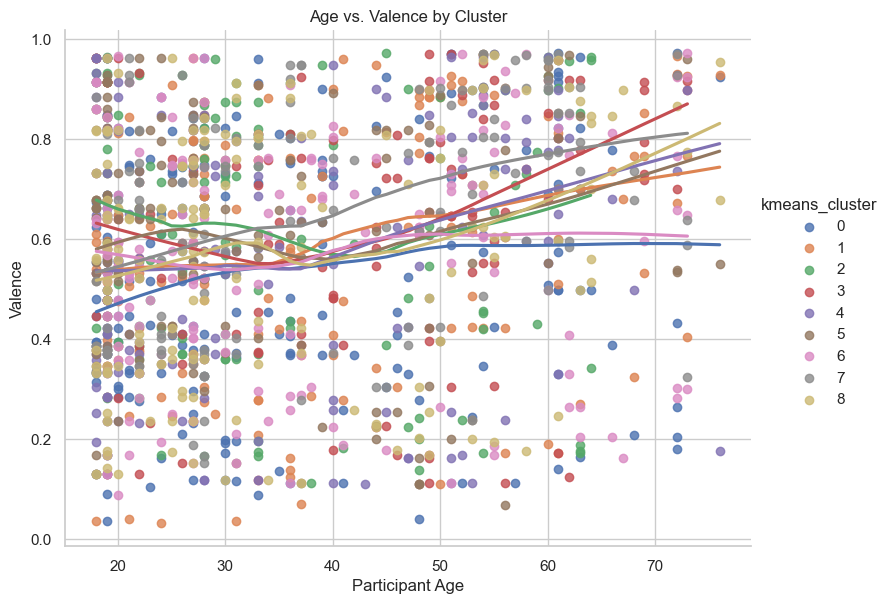

In [54]:
import seaborn as sns

# Create the plot
g = sns.lmplot(
    x="Age", y="valence", hue="kmeans_cluster",
    data=df_main, lowess=True, height=6, aspect=1.3
)
g.set_axis_labels("Participant Age", "Valence")
g.set(title="Age vs. Valence by Cluster")

# Save the correct way for Seaborn plots
g.savefig("age_vs_valence_by_cluster_fixed.png", dpi=300, bbox_inches='tight')


In [55]:
# Create coefficient table for valence
valence_results_df = pd.DataFrame({
    "term": valence_model.params.index,
    "coefficient": valence_model.params.values,
    "std_error": valence_model.bse.values,
    "t_value": valence_model.tvalues.values,
    "p_value": valence_model.pvalues.values
})
valence_results_df.to_csv("ols_valence_model_results.csv", index=False)

# Create coefficient table for arousal
arousal_results_df = pd.DataFrame({
    "term": arousal_model.params.index,
    "coefficient": arousal_model.params.values,
    "std_error": arousal_model.bse.values,
    "t_value": arousal_model.tvalues.values,
    "p_value": arousal_model.pvalues.values
})
arousal_results_df.to_csv("ols_arousal_model_results.csv", index=False)

In [40]:
valence_model.params.to_csv(os.path.join(root, 'output', 'valence_model_coefficients.csv'))
arousal_model.params.to_csv(os.path.join(root, 'output', 'arousal_model_coefficients.csv'))

C:\Users\james\AppData\Local\Temp\ipykernel_27628\3131773958.py:17: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


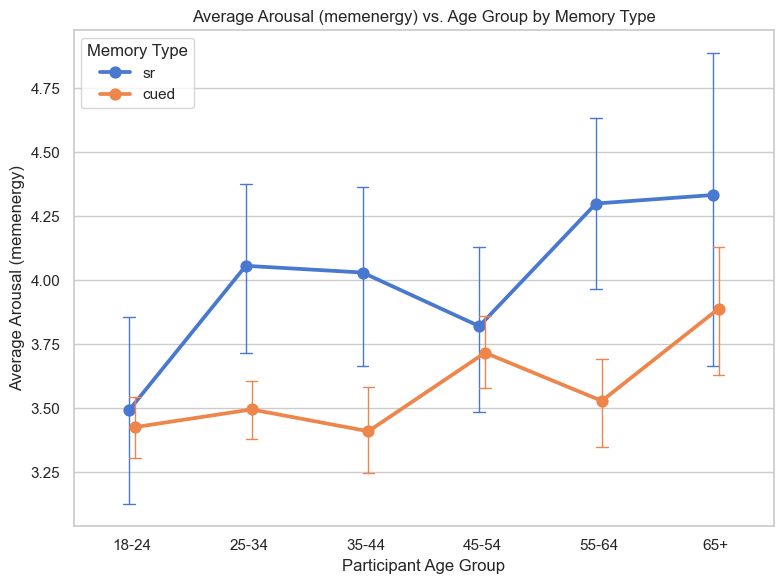

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the age bins
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Create AgeGroup column
df_main['AgeGroup'] = pd.cut(df_main['Age'], bins=bins, labels=labels, right=False)

# Set the figure size and style
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')

# Use seaborn pointplot to show mean with 95% CI
sns.pointplot(
    data=df_main,
    x='AgeGroup',
    y='memenergy',
    hue='cuedorsr',
    dodge=True,
    markers='o',
    capsize=.1,
    errwidth=1,
    palette='muted'
)

# Final plot formatting
plt.title("Average Arousal (memenergy) vs. Age Group by Memory Type")
plt.xlabel("Participant Age Group")
plt.ylabel("Average Arousal (memenergy)")
plt.legend(title='Memory Type')
plt.tight_layout()
plt.savefig("age_vs_arousal_pointplot.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

C:\Users\james\AppData\Local\Temp\ipykernel_27628\543124085.py:17: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


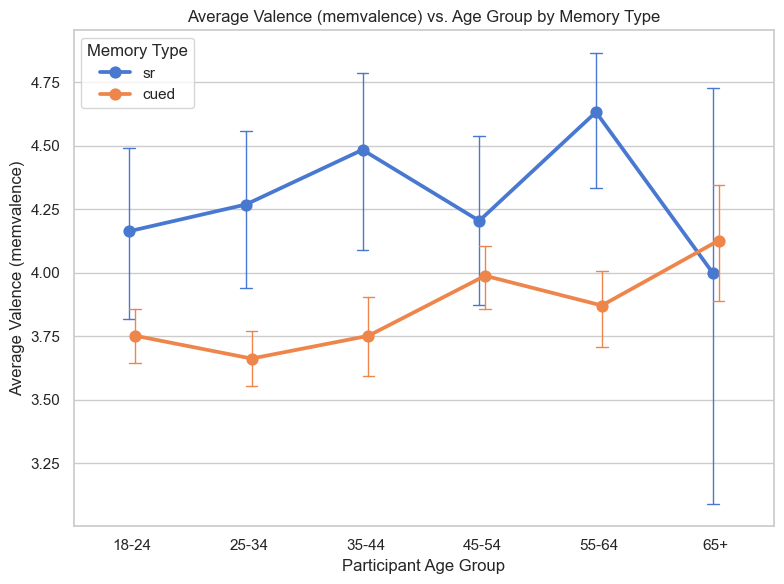

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the age bins
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Create AgeGroup column
df_main['AgeGroup'] = pd.cut(df_main['Age'], bins=bins, labels=labels, right=False)

# Set the figure size and style
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')

# Seaborn pointplot for valence with confidence intervals
sns.pointplot(
    data=df_main,
    x='AgeGroup',
    y='memvalence',
    hue='cuedorsr',
    dodge=True,
    markers='o',
    capsize=.1,
    errwidth=1,
    palette='muted'
)

# Final plot formatting
plt.title("Average Valence (memvalence) vs. Age Group by Memory Type")
plt.xlabel("Participant Age Group")
plt.ylabel("Average Valence (memvalence)")
plt.legend(title='Memory Type')
plt.tight_layout()
plt.savefig("age_vs_valence_pointplot.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


C:\Users\james\AppData\Local\Temp\ipykernel_27628\1559224713.py:30: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


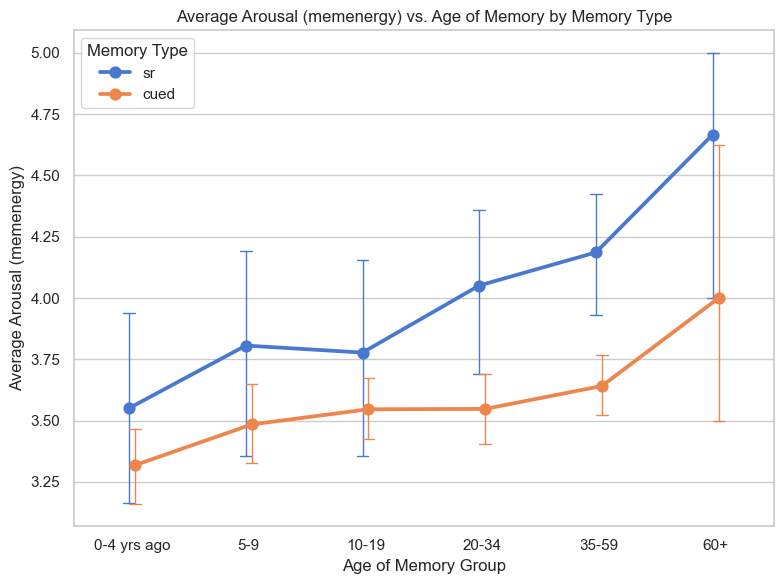

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make sure age_of_memory is numeric
df_main['age_of_memory'] = pd.to_numeric(df_main['age_of_memory'], errors='coerce')
df_main['memenergy'] = pd.to_numeric(df_main['memenergy'], errors='coerce')
df_main['cuedorsr'] = df_main['cuedorsr'].astype(str).str.lower().str.strip()

# Drop rows with any missing relevant values
df_filtered = df_main.dropna(subset=['age_of_memory', 'memenergy', 'cuedorsr'])

# Only include rows with cued or sr
df_filtered = df_filtered[df_filtered['cuedorsr'].isin(['cued', 'sr'])]

# Define bins and labels
bins = [0, 5, 10, 20, 35, 60, 100]
labels = ['0-4 yrs ago', '5-9', '10-19', '20-34', '35-59', '60+']

# Create age_of_memory_group
df_filtered['age_of_memory_group'] = pd.cut(df_filtered['age_of_memory'], bins=bins, labels=labels, right=False)

# Check binning result (optional debug line)
# print(df_filtered['age_of_memory_group'].value_counts())

# Plot
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')

sns.pointplot(
    data=df_filtered,
    x='age_of_memory_group',
    y='memenergy',
    hue='cuedorsr',
    dodge=True,
    markers='o',
    capsize=.1,
    errwidth=1,
    palette='muted'
)

plt.title("Average Arousal (memenergy) vs. Age of Memory by Memory Type")
plt.xlabel("Age of Memory Group")
plt.ylabel("Average Arousal (memenergy)")
plt.legend(title='Memory Type')
plt.tight_layout()
plt.savefig("age_of_memory_vs_arousal_pointplot_FINAL.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

C:\Users\james\AppData\Local\Temp\ipykernel_27628\2085316762.py:23: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


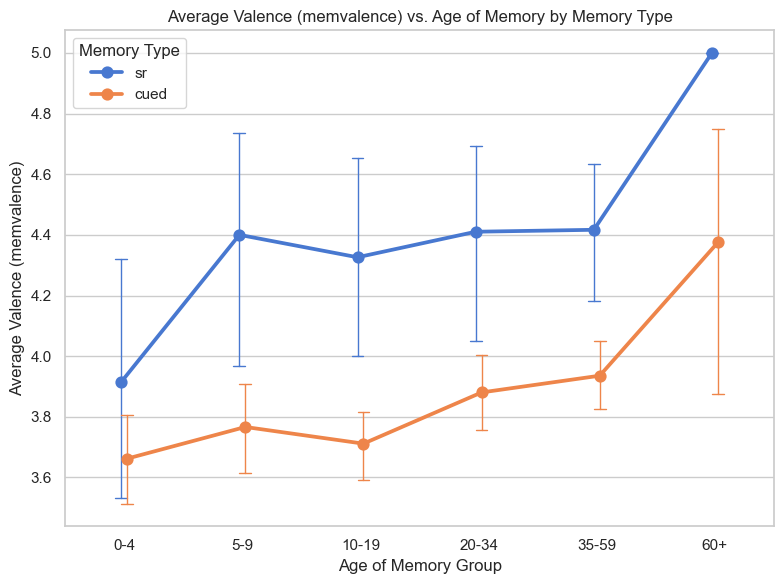

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure columns are properly typed
df_main['age_of_memory'] = pd.to_numeric(df_main['age_of_memory'], errors='coerce')
df_main['memvalence'] = pd.to_numeric(df_main['memvalence'], errors='coerce')
df_main['cuedorsr'] = df_main['cuedorsr'].astype(str).str.lower().str.strip()

# Drop rows with missing values
df_filtered = df_main.dropna(subset=['age_of_memory', 'memvalence', 'cuedorsr'])
df_filtered = df_filtered[df_filtered['cuedorsr'].isin(['cued', 'sr'])]

# Dynamically define bins if needed
bins = [0, 5, 10, 20, 35, 60, df_filtered['age_of_memory'].max() + 1]
labels = ['0-4', '5-9', '10-19', '20-34', '35-59', '60+']
df_filtered['age_of_memory_group'] = pd.cut(df_filtered['age_of_memory'], bins=bins, labels=labels, right=False)

# Plot
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')

sns.pointplot(
    data=df_filtered,
    x='age_of_memory_group',
    y='memvalence',
    hue='cuedorsr',
    dodge=True,
    markers='o',
    capsize=.1,
    errwidth=1,
    palette='muted'
)

plt.title("Average Valence (memvalence) vs. Age of Memory by Memory Type")
plt.xlabel("Age of Memory Group")
plt.ylabel("Average Valence (memvalence)")
plt.legend(title='Memory Type')
plt.tight_layout()
plt.savefig("age_of_memory_vs_valence_pointplot_FINAL.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


C:\Users\james\AppData\Local\Temp\ipykernel_28660\2441735717.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_means = df_main.groupby('kmeans_cluster')[['memvalence', 'memenergy']].mean().reset_index()
C:\Users\james\AppData\Local\Temp\ipykernel_28660\2441735717.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\james\AppData\Local\Temp\ipykernel_28660\2441735717.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


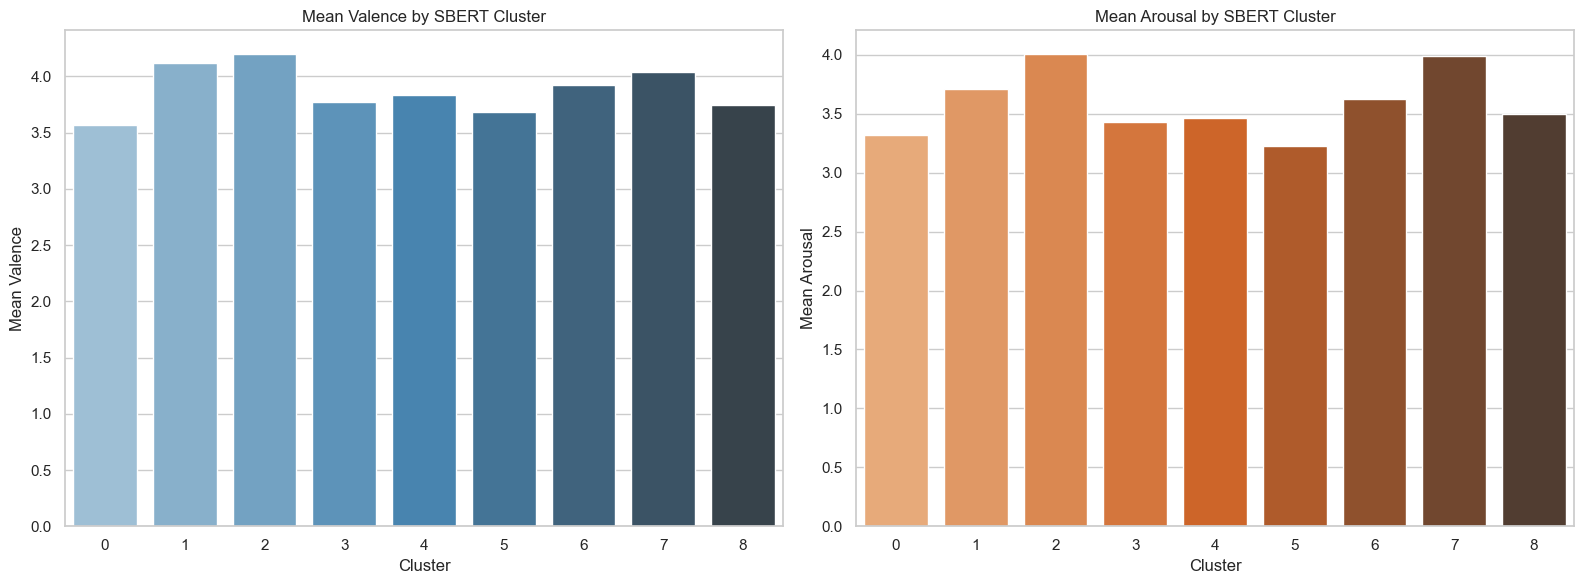

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Group by kmeans cluster and calculate mean valence and arousal
cluster_means = df_main.groupby('kmeans_cluster')[['memvalence', 'memenergy']].mean().reset_index()

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set(style='whitegrid')

# Plot mean valence
sns.barplot(
    data=cluster_means,
    x='kmeans_cluster',
    y='memvalence',
    palette='Blues_d',
    ax=axes[0]
)
axes[0].set_title("Mean Valence by SBERT Cluster")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Mean Valence")

# Plot mean arousal
sns.barplot(
    data=cluster_means,
    x='kmeans_cluster',
    y='memenergy',
    palette='Oranges_d',
    ax=axes[1]
)
axes[1].set_title("Mean Arousal by SBERT Cluster")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Mean Arousal")

plt.tight_layout()
plt.savefig("cluster_mean_valence_arousal.png", dpi=300, bbox_inches='tight')
plt.show()



C:\Users\james\AppData\Local\Temp\ipykernel_28660\1860903014.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\james\AppData\Local\Temp\ipykernel_28660\1860903014.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\james\AppData\Local\Temp\ipykernel_28660\1860903014.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\james\AppData\Local\Temp\ipykernel_28660\1860903014.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `h

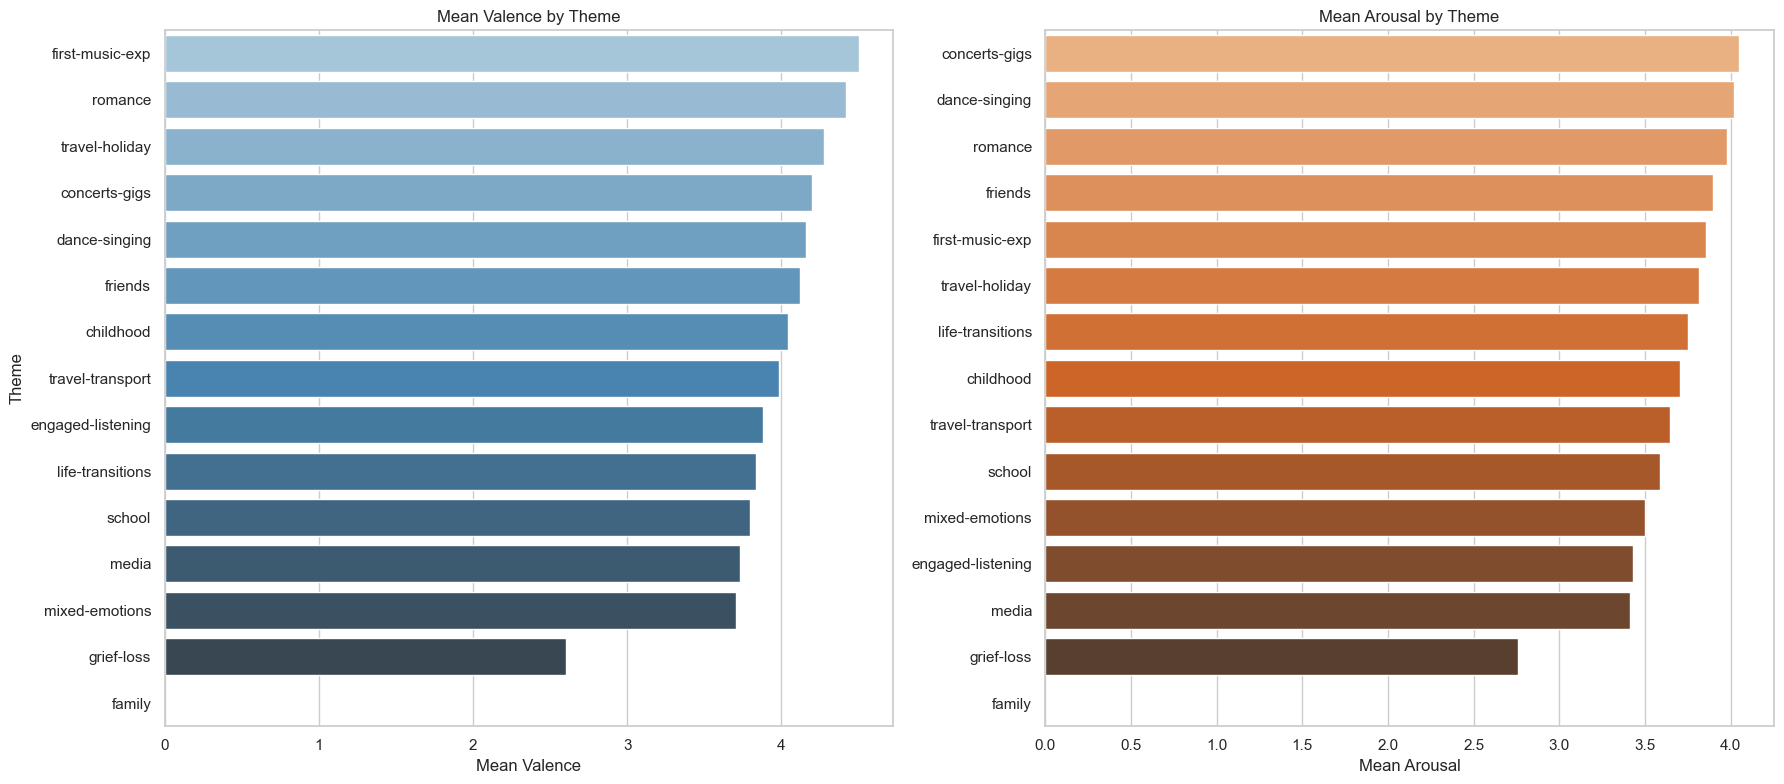

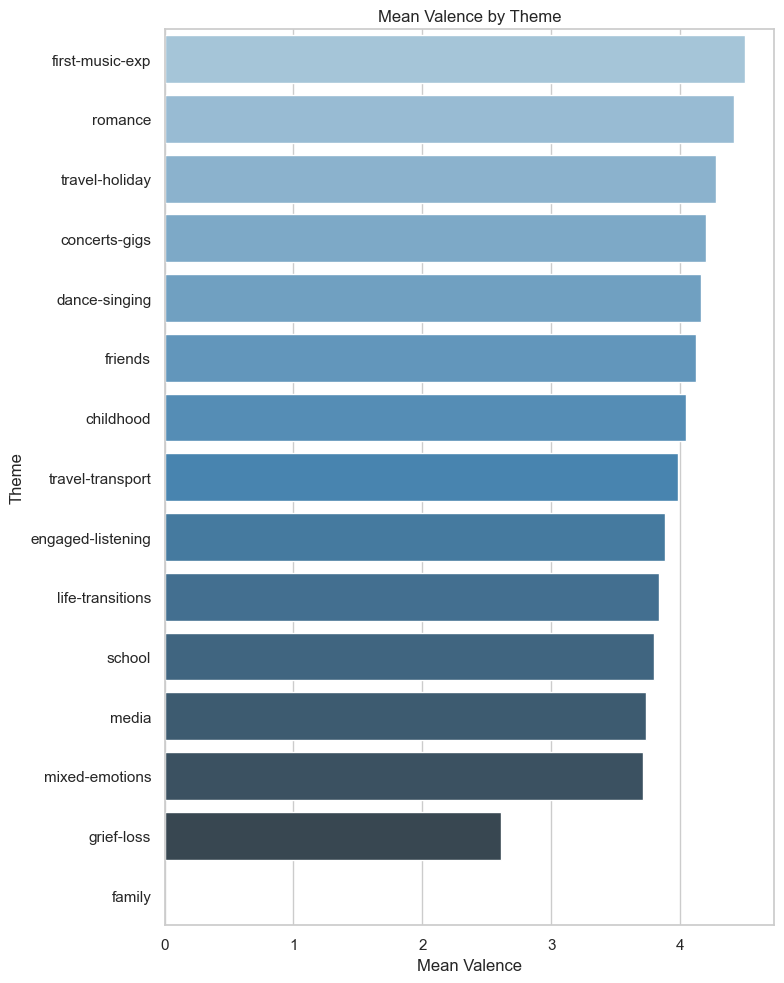

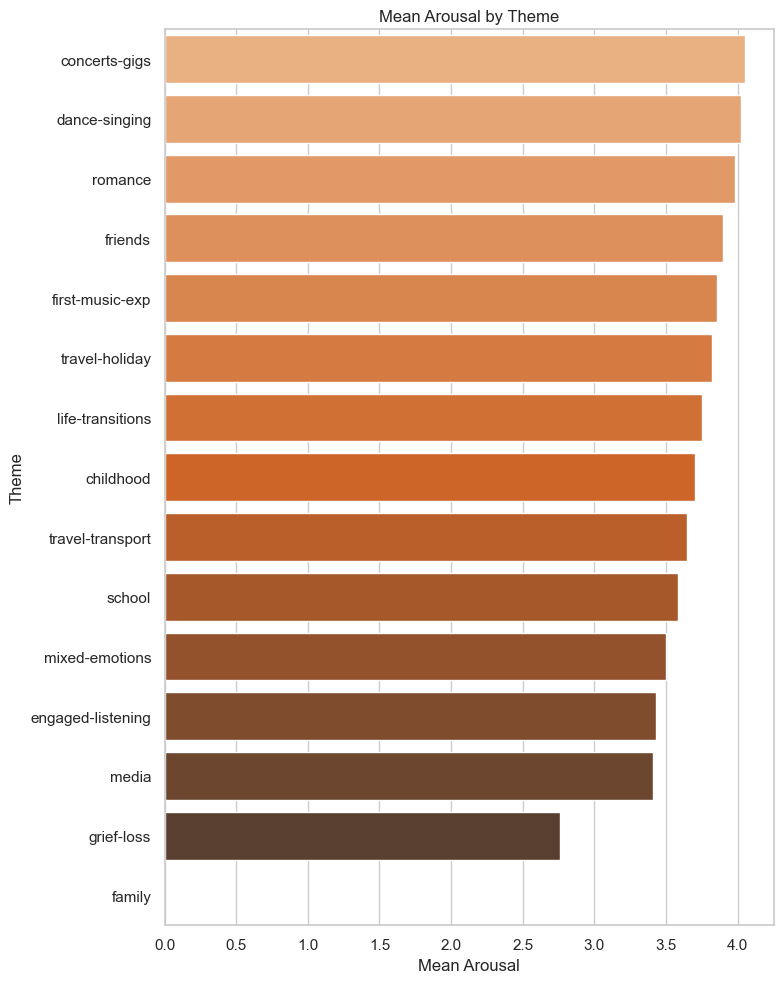

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# List of thematic coding columns (update with your actual column names if different)
theme_columns = [
    'family', 'travel-holiday', 'school', 'concerts-gigs', 'media', 'dance-singing', 
    'romance', 'friends', 'childhood', 'life-transitions', 'grief-loss',
    'mixed-emotions', 'engaged-listening', 'first-music-exp',
    'travel-transport' 
]

# Prepare empty lists for results
theme_names = []
mean_valence = []
mean_arousal = []

# Loop through each theme
for theme in theme_columns:
    # Select memories where the theme is present
    subset = df_main[df_main[theme] == 1]
    
    # Calculate mean valence and arousal
    mean_valence.append(subset['memvalence'].mean())
    mean_arousal.append(subset['memenergy'].mean())
    theme_names.append(theme)

# Create summary DataFrame
theme_summary = pd.DataFrame({
    'theme': theme_names,
    'mean_valence': mean_valence,
    'mean_arousal': mean_arousal
})

# Plot side-by-side
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Valence plot
sns.barplot(
    data=theme_summary.sort_values('mean_valence', ascending=False),
    x='mean_valence',
    y='theme',
    palette='Blues_d',
    ax=axes[0]
)
axes[0].set_title("Mean Valence by Theme")
axes[0].set_xlabel("Mean Valence")
axes[0].set_ylabel("Theme")

# Arousal plot
sns.barplot(
    data=theme_summary.sort_values('mean_arousal', ascending=False),
    x='mean_arousal',
    y='theme',
    palette='Oranges_d',
    ax=axes[1]
)
axes[1].set_title("Mean Arousal by Theme")
axes[1].set_xlabel("Mean Arousal")
axes[1].set_ylabel("")

plt.tight_layout()

# Save the full figure
fig.savefig("theme_mean_valence_arousal_combined.png", dpi=300, bbox_inches='tight')

# Optional: Save individual plots if needed
fig_valence, ax_valence = plt.subplots(figsize=(8, 10))
sns.barplot(
    data=theme_summary.sort_values('mean_valence', ascending=False),
    x='mean_valence',
    y='theme',
    palette='Blues_d',
    ax=ax_valence
)
ax_valence.set_title("Mean Valence by Theme")
ax_valence.set_xlabel("Mean Valence")
ax_valence.set_ylabel("Theme")
plt.tight_layout()
fig_valence.savefig("theme_mean_valence_only.png", dpi=300, bbox_inches='tight')

fig_arousal, ax_arousal = plt.subplots(figsize=(8, 10))
sns.barplot(
    data=theme_summary.sort_values('mean_arousal', ascending=False),
    x='mean_arousal',
    y='theme',
    palette='Oranges_d',
    ax=ax_arousal
)
ax_arousal.set_title("Mean Arousal by Theme")
ax_arousal.set_xlabel("Mean Arousal")
ax_arousal.set_ylabel("Theme")
plt.tight_layout()
fig_arousal.savefig("theme_mean_arousal_only.png", dpi=300, bbox_inches='tight')

# Show final combined plot
plt.show()

C:\Users\james\AppData\Local\Temp\ipykernel_28660\323201846.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['cuedorsr'] = df_plot['cuedorsr'].astype(str).str.lower().str.strip()
C:\Users\james\AppData\Local\Temp\ipykernel_28660\323201846.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['memvalence_jittered'] = df_plot['memvalence'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_plot))
C:\Users\james\AppData\Local\Temp\ipykernel_28660\323201846.py:15: SettingWithCo

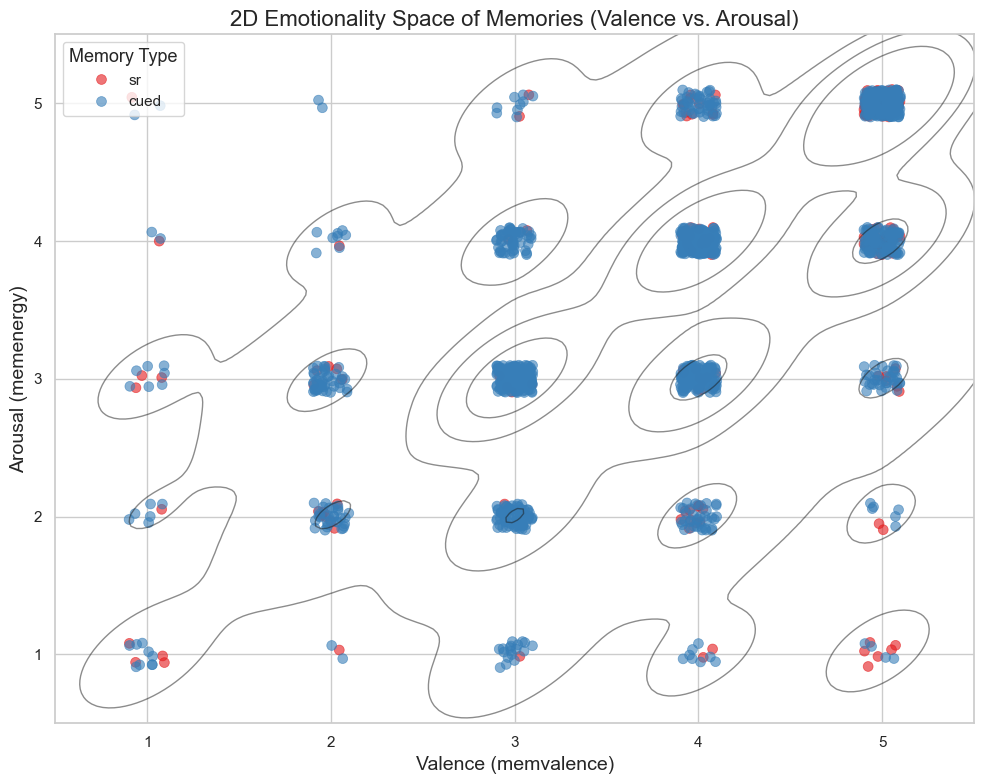

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Clean data
df_plot = df_main.dropna(subset=['memvalence', 'memenergy', 'cuedorsr'])
df_plot['cuedorsr'] = df_plot['cuedorsr'].astype(str).str.lower().str.strip()

# Add jitter manually
np.random.seed(42)  # for reproducibility
jitter_strength = 0.1  # adjust this if needed

df_plot['memvalence_jittered'] = df_plot['memvalence'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_plot))
df_plot['memenergy_jittered'] = df_plot['memenergy'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_plot))

# Set up plot
plt.figure(figsize=(10, 8))
sns.set(style='whitegrid')

# Scatterplot with manual jitter
sns.scatterplot(
    data=df_plot,
    x='memvalence_jittered',
    y='memenergy_jittered',
    hue='cuedorsr',
    palette='Set1',
    alpha=0.6,
    edgecolor=None,
    s=50
)

# Add 2D density contours
sns.kdeplot(
    data=df_plot,
    x='memvalence_jittered',
    y='memenergy_jittered',
    levels=5,
    color='k',
    linewidths=1,
    alpha=0.5
)

# Labels and titles
plt.title('2D Emotionality Space of Memories (Valence vs. Arousal)', fontsize=16)
plt.xlabel('Valence (memvalence)', fontsize=14)
plt.ylabel('Arousal (memenergy)', fontsize=14)
plt.legend(title='Memory Type', title_fontsize='13', fontsize='11')
plt.xlim(0.5, 5.5)  # Widen slightly to fit jitter
plt.ylim(0.5, 5.5)
plt.grid(True)

# Save the plot
plt.tight_layout()
plt.savefig('emotionality_space_valence_arousal_jittered_density.png', dpi=300, bbox_inches='tight')
plt.show()
